In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


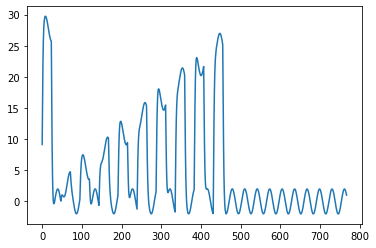

In [2]:
# GET OBSERVATIONS
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
OBSERVATIONS_LIST = []
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)
cfe_obs.finalize()
plt.plot(OBSERVATIONS_LIST)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)

<module 'bmi_cfe_open' from '/home/jovyan/data/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from '/home/jovyan/data/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from '/home/jovyan/data/NextGen---The-Simulators-/Toy_Model/./Assimilation/Bmi_da_ENKF_forSBMI.py'>


In [5]:

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


              time  APCP_surface      T2D       Q2D     U2D     V2D  \
0     5/15/17 0:00            10  284.078  0.006616  6.0804 -1.9670   
1     5/15/17 1:00            10  283.180  0.006650  6.0304 -2.0740   
2     5/15/17 2:00            10  282.440  0.006614  5.9856 -2.1828   
3     5/15/17 3:00            10  281.662  0.006476  5.9402 -2.2888   
4     5/15/17 4:00            10  281.702  0.006530  6.3688 -2.5458   
..             ...           ...      ...       ...     ...     ...   
763  6/15/17 19:00             0  295.270  0.007334 -1.1600  4.5018   
764  6/15/17 20:00             0  294.610  0.006788 -1.2230  4.4990   
765  6/15/17 21:00             0  293.624  0.006776 -1.2812  4.4996   
766  6/15/17 22:00             0  292.722  0.006714 -1.5682  3.8524   
767  6/15/17 23:00             0  291.554  0.006650 -1.8486  3.1996   

          PSFC   SWDOWN   LWDOWN  
0     98376.98    0.000  318.822  
1     98378.60    0.000  317.996  
2     98380.28    0.000  317.736  
3     9

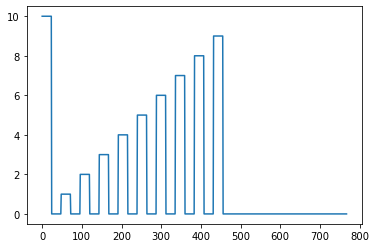

In [6]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [7]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    obs = OBSERVATIONS_LIST[i]
    enkf.set_value('validity', 1)
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
   
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then update
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs]))
    enkf.update()
    
    # For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get new EnKF state vars to give back to CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    
    # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 
        
    # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    
    # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()

soil_storage_deficit_from CFE 0
over estimaiton ratio [0.96174848]
new value [0.69205364]
CFE [7.51395073]
enkf [7.22653072]
soil_storage_deficit_from CFE 0
over estimaiton ratio [0.58009768]
new value [0.7462894]
CFE [17.47086333]
enkf [10.13480723]
soil_storage_deficit_from CFE 0
over estimaiton ratio [0.34359118]
new value [0.58439778]
CFE [28.20850881]
enkf [9.6921949]
soil_storage_deficit_from CFE 0
over estimaiton ratio [0.40735022]
new value [0.79060286]
CFE [26.04299691]
enkf [10.60862044]
soil_storage_deficit_from CFE 0
over estimaiton ratio [0.65117126]
new value [1.34912412]
CFE [24.21418788]
enkf [15.76758331]
soil_storage_deficit_from CFE 0
over estimaiton ratio [0.23170552]
new value [0.49525617]
CFE [29.2832379]
enkf [6.78508783]
soil_storage_deficit_from CFE 0
over estimaiton ratio [0.60551392]
new value [1.30756119]
CFE [23.78321527]
enkf [14.40106801]
soil_storage_deficit_from CFE 0
over estimaiton ratio [0.56451921]
new value [1.23144097]
CFE [30.33847353]
enkf [17.1

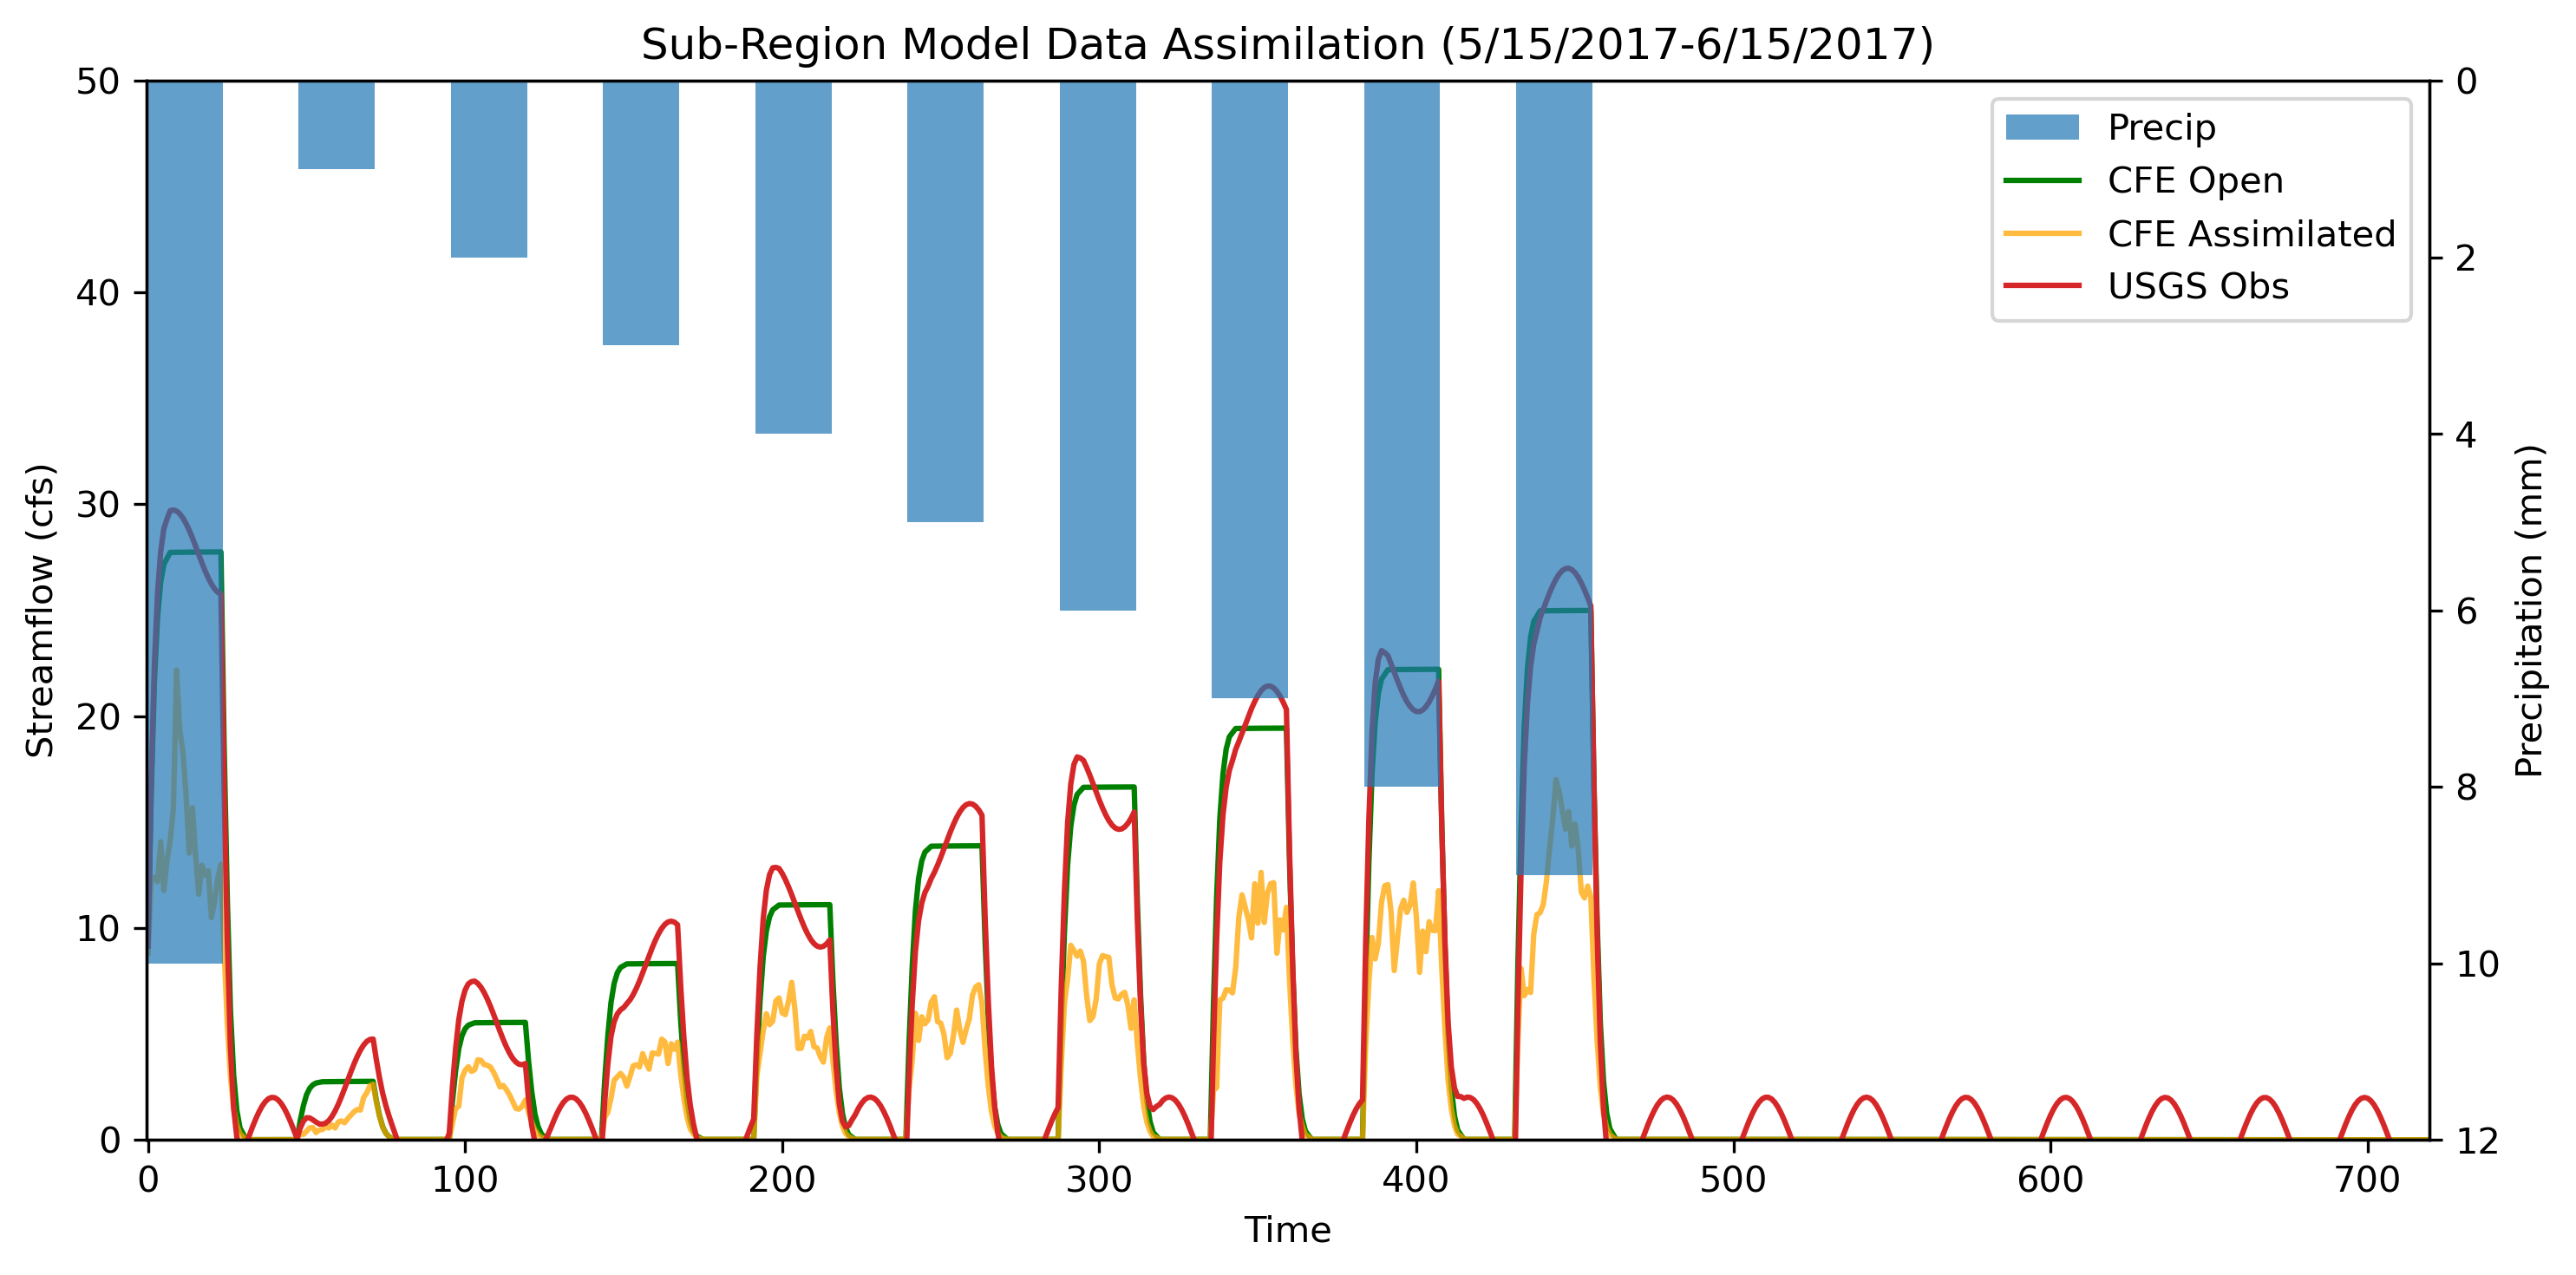

In [8]:
istart_plot=0
iend_plot=720
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
ax1.set_ylim(0,50,1)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(x, OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', label = 'USGS Obs')

plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [9]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,9.148032,8.798174,9.148032
1,16.752527,12.238561,16.355189
2,22.401837,12.390315,21.623001
3,25.803301,12.192425,24.674016
4,27.774125,14.074164,26.339413
...,...,...,...
763,1.946724,0.000655,0.000655
764,1.816271,0.000645,0.000645
765,1.613436,0.000634,0.000634
766,1.346303,0.000624,0.000624


In [10]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9847685621870116
KGE_open= 0.9738968324390085
NSE_open= 0.9684789130731811
PBias= -0.5190748263743952
r_analysis= 0.9723272739079095
KGE_analysis= -0.4620076746531956
NSE_analysis= -0.500353642939956
PBias= -105.76702834315104
mean_obs= 4.800312978052864
STD_obs= 8.136825159788627
mean_open= 4.7755244328943505
STD_open= 7.972955267955368
mean_analysis= 2.33288735163514
STD_analysis= 4.050233462263142
